## Experimenting with Rewards
    In this notebook, we will experiment with different ways of rewarding the agent and comparing them.

In [51]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
from matplotlib import pyplot as plot
import numpy as np
import matplotlib.pyplot as plt

In [52]:
class State:
    def __init__(self, x, y):
        self.x = x
        self.y = y

up = lambda state: State(state.x, state.y-1)
down = lambda state: State(state.x, state.y+1)
left = lambda state: State(state.x - 1, state.y)
right = lambda state: State(state.x + 1, state.y)
action_space_size = 4
state_space_size = 63
action_space = [up, down, left, right]

def get_sample():
    random_pos = np.random.randint(0,4)
    return action_space[random_pos], random_pos

def get_num_state(state):
    return state.y*9 + state.x

def reset():
    initial_state = State(1,1)
    return initial_state,get_num_state(initial_state)

def is_goal_state(state):
    return state.x == 7 and state.y == 4

def move(state, action):
    wind_val = {3:0.1, 4:0.2, 5:0.15}
    new_state = action(state)
    wind_treshold = np.random.random()
    wind_prob = wind_val.get(new_state.x)
    if wind_prob:
        if wind_treshold < wind_prob:
            new_state.y -= 1
    reward = get_reward(new_state)
    done = is_goal_state(new_state) or reward == -10
    if reward == -10:
        new_state = None
    return new_state, reward, done

def rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate):
    # This cycle is to calculate the average reward/episodes and its only purpose is to plot the nice graph below that
# shows how the agent learns to maximize the reward.
    rewards_avg = []
    q_table_avg = []
    num_times_goal_reached_avg = []
    for it in range(100):
        #print('average ', it)
        rewards_all_episodes=[]
        q_table_all_episodes = []
        num_times_goal_reached = 0
        # exporation-exploitation trade-off params
        exploration_rate = 1

        # init q table in zeros
        q_table = np.zeros((state_space_size, action_space_size))

        # iterate over the episodes
        for episode in range(num_episodes):
            state, num_state = reset()
            done = False
            rewards_current_episode = 0

            # iterate over the steps for an episode
            for step in range(max_steps_per_episode):
                # Exploration-exploitation trade-off
                exploration_rate_threshold = np.random.random()
                if exploration_rate_threshold <= exploration_rate:
                    action, pos_action = get_sample()
                else:
                    q_row = q_table[num_state]
                    pos_action = np.where(q_row == max(q_row))[0][0]
                    action = action_space[pos_action]
                # Take action
                new_state, reward, done = move(state, action)
                if new_state == None:
                    num_new_state = get_num_state(state)
                else:
                    num_new_state = get_num_state(new_state)
                # Update Q-table for Q(s,a)
                max_value = max(q_table[num_new_state])
                future_q=learning_rate*(reward + discount_rate*max_value)
                q_table[num_state, pos_action] = (1-learning_rate)*q_table[num_state,pos_action] + future_q

                # transition next state
                state = new_state
                num_state = num_new_state
                rewards_current_episode += reward
                        
                if done == True: 
                    break

            # Exploration rate decay
            exploration_rate = min_exploration_rate + (max_exploration_rate-min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
            
            if state!=None and is_goal_state(state):
                num_times_goal_reached += 1
                
            rewards_all_episodes.append(rewards_current_episode)
            q_table_all_episodes.append(q_table)
            
        num_times_goal_reached_avg.append(num_times_goal_reached)        
        rewards_avg.append(rewards_all_episodes)
        q_table_avg.append(q_table_all_episodes)
    return rewards_avg, q_table, num_times_goal_reached_avg
        
def plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath):
    x = [i for i in range(0,num_episodes)]
    y = np.mean(rewards_avg, axis=0)
    plot.xlabel('Episodes')
    plot.ylabel('Reward')
    plot.plot(x, y,'o')
    plot.title("Episodes_vs_Rewards")
    plt.savefig(filepath)
    plt.show()
    
def get_state_actions(q_table):
    q_table_best_actions =[]
    for i in range(q_table.shape[0]):
        max_pos = np.argmax(q_table[i])
        q_table_best_actions.append(max_pos)
    return q_table_best_actions
    
def plot_optimal_policy(q_table, filepath):
    w = 0.3
    i,j=0,0
    best_actions_matrix = np.array(get_state_actions(q_table)).reshape(7,9)
    arrow_dict = {0:lambda i,j:plt.arrow(x=i, y=j-0.25, dx=0, dy=w, width=.05)  ,1:lambda i,j:plt.arrow(x=i, y=j+0.25, dx=0, dy=-w, width=.05),2:lambda i,j:plt.arrow(x=i+0.2, y=j, dx=-w, dy=0, width=.05),3:lambda i,j:plt.arrow(x=i-0.2, y=j, dx=w, dy=0, width=.05)}
    arrow_matrix=np.transpose(np.array(best_actions_matrix).reshape(7,9))
    for j in range(len(arrow_matrix)):
        for i in range(len(arrow_matrix[j])):
            arrow_dict[best_actions_matrix[i,j]](j+0.5,(6-i)+0.5)
    start = [1,1]
    goal = [7,4]
    plt.scatter(start[0]+0.5,6-start[1]+0.5, color="green", linewidths=20)
    plt.scatter(goal[0]+0.5,6-goal[1]+0.5, color = "blue",linewidths=20)
    plt.xticks(np.arange(9,-1, -1))
    plt.yticks(np.arange(7,-1, -1),labels= ["0","1","2","3","4","5","6","7"])
    plt.grid()
    plt.title("Optimal_Policy_Actions")
    # display plot 
    plt.savefig(filepath)
    plt.show()

def get_max_reward_avg_episode(rewards_avg):
    max_rew_avg = []
    for rew in rewards_avg:
        max_rew_pos = np.argmax(np.array(rew))
        max_rew_avg.append(max_rew_pos)
    return np.mean(max_rew_avg)
    
def save_rewards(filename, rewards_avg):
    np.save(filename,rewards_avg)
    
def load_rewards(filename):
    rewards_avg =np.load(filename)
    return rewards_avg

#### Version 1
    Our first way of rewarding the agent will be:
        1. -10 points if the agent gets out of the gameboard
        2. 126 points if the agent reaches the goal state
        3. -1 point for every step the agent makes
    We decided to give 126 points for the agent know it has to reach the goal to maximize the reward, and we decided to penalize every step the agent makes, for the agent to find the most efficient path.

In [30]:
def get_reward(state):
    if state.x not in range(9) or state.y not in range(7):
        return -10
    if is_goal_state(state):
        return 126
    return -1

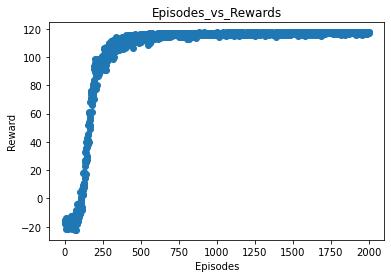

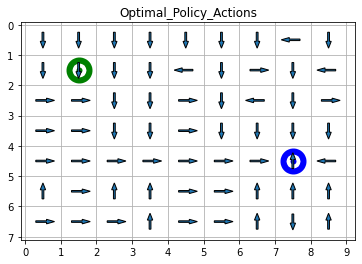

Average number of times goal was reached:  1826.83  representing 91.3415 %
Average episode number in which the agent was able to learn:  165.5


In [31]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v1.jpg"
filepath_optimal_policy = "optimal_policies/v1.jpg"
filepath_rewards = "rewards/rewards_v1.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

#### Version 2
    Our second way of rewarding the agent will be:
        1. -10 points if the agent gets out of the gameboard
        2. 260 points if the agent reaches the goal state
        3. 2 points for every step the agent makes

In [14]:
def get_reward(state):
    if state.x not in range(9) or state.y not in range(7):
        return -10
    if is_goal_state(state):
        return 260
    return 2

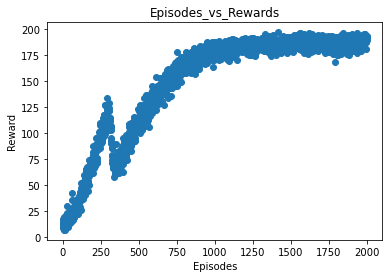

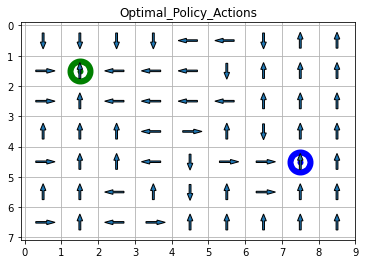

Average number of times goal was reached:  1.74  representing 0.087 %
Average episode number in which the agent was able to learn:  103.06


In [15]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v2.jpg"
filepath_optimal_policy = "optimal_policies/v2.jpg"
filepath_rewards = "rewards/rewards_v2.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

#### Version 3
    Our third way of rewarding the agent will be:
        1. 0 points if the agent gets out of the gameboard
        2. 1 point if the agent reaches the goal state
        3. 0 points for every step the agent makes
    This way of rewarding is based on the lab practice for the Frozen Lake exercise, in which we identified that the agent got 0 reward when falling to a hole or getting out of the gameboard, and 1 of reward when reagching the goal state.

In [60]:
def is_out_of_range(state):
    return state.x not in range(9) or state.y not in range(7)
    
def get_reward(state):
    if is_out_of_range(state):
#         print(state.x,state.y)
        return -1, True
    if is_goal_state(state):
        return 1, False
    return 0, False

In [61]:
def move(state, action):
    wind_val = {3:0.1, 4:0.2, 5:0.15}
    new_state = action(state)
    wind_treshold = np.random.random()
    wind_prob = wind_val.get(new_state.x)
    if wind_prob:
        if wind_treshold < wind_prob:
            new_state.y -= 1
    reward, out_of_range = get_reward(new_state)
    #out_of_range = is_out_of_range(new_state)
    done = is_goal_state(new_state) or out_of_range
    if out_of_range:
        new_state = None
    return new_state, reward, done

In [54]:
def move(state, action):
    wind_val = {3:0.1, 4:0.2, 5:0.15}
    new_state = action(state)
    wind_treshold = np.random.random()
    wind_prob = wind_val.get(new_state.x)
    if wind_prob:
        if wind_treshold < wind_prob:
            new_state.y -= 1
    reward = get_reward(new_state)
    done = is_goal_state(new_state) or reward == -1
    if reward == -1:
        new_state = None
    return new_state, reward, done

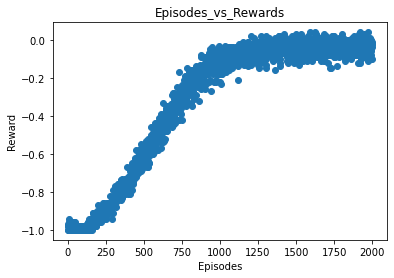

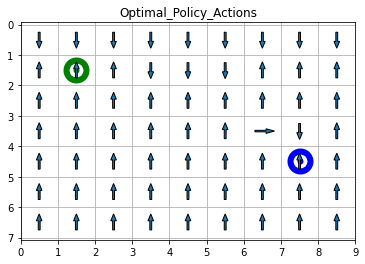

Average number of times goal was reached:  155.05  representing 7.752500000000001 %
Average episode number in which the agent was able to learn:  144.87


In [59]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v3.jpg"
filepath_optimal_policy = "optimal_policies/v3.jpg"
filepath_rewards = "rewards/rewards_v3.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

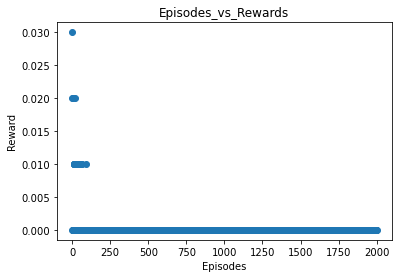

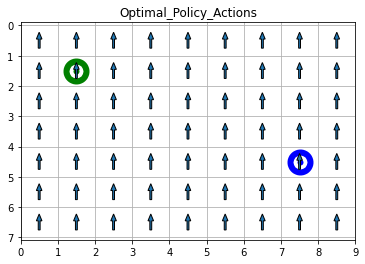

Average number of times goal was reached:  0.29  representing 0.0145 %
Average episode number in which the agent was able to learn:  5.56


In [62]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v4.jpg"
filepath_optimal_policy = "optimal_policies/v4.jpg"
filepath_rewards = "rewards/rewards_v4.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

In [128]:
# r_a = load_rewards("rewards/rewards_v11.npy")
# print(r_a)

[[-14 -13 -23 ... 118 117 115]
 [-11 -13 -15 ... 118 117 118]
 [-16 -16 -15 ... 118 116 118]
 ...
 [-26 -15 -12 ... 118 116 117]
 [-14 -13 -17 ... 118 118 116]
 [-50 -36 -30 ... 118 118 117]]
